## Data Preprocessing

In [11]:
import cv2,os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense,Dropout
from keras.callbacks import ModelCheckpoint

In [2]:
path = 'mask_dataset'

categories = os.listdir(path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories,labels))

print(label_dict)

{'without_mask': 0, 'with_mask': 1}


In [3]:
data = []
target = []

for category in categories:
    folder_path = os.path.join(path, category)
    img_names = os.listdir(folder_path)
    
    for img_name in img_names:
        img_path = os.path.join(folder_path,img_name)
        img = cv2.imread(img_path)
        
        try:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = cv2.resize(gray_img, (100,100))
            data.append(resized_img)
            target.append(label_dict[category])
            
        except Exception as e:
            print('Exception:', e)

In [4]:
data = np.array(data)/255.0
data = np.reshape(data,(data.shape[0],100,100,1))
target = np.array(target)

target = np_utils.to_categorical(target)

## Training the CNN 

In [5]:
classifier = Sequential()

# Adding a convulation layer followed by MaxPooling layers
classifier.add(Conv2D(filters=200, kernel_size=(3,3), input_shape=data.shape[1:], activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Conv2D(32, (3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Adding the flattening layer
classifier.add(Flatten())
classifier.add(Dropout(0.5)) # to get rid of overfitting

classifier.add(Dense(units=50, activation='relu'))
classifier.add(Dense(units=2, activation='softmax'))

classifier.compile(optimizer = 'adam', loss  = 'categorical_crossentropy', metrics = ['accuracy'])

In [6]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 200)       2000      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        57632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                8

In [7]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.1)

In [10]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = classifier.fit(train_data,
                         train_target, 
                         epochs=20,
                         #callbacks=[checkpoint],
                         validation_split=0.2)

Epoch 1/20
31/31 [==============================] - 59s 2s/step - loss: 0.6796 - accuracy: 0.5707 - val_loss: 0.6222 - val_accuracy: 0.5524
Epoch 2/20
31/31 [==============================] - 48s 2s/step - loss: 0.5093 - accuracy: 0.7525 - val_loss: 0.3972 - val_accuracy: 0.8669
Epoch 3/20
31/31 [==============================] - 47s 2s/step - loss: 0.3101 - accuracy: 0.8768 - val_loss: 0.2897 - val_accuracy: 0.8911
Epoch 4/20
31/31 [==============================] - 47s 2s/step - loss: 0.2566 - accuracy: 0.8990 - val_loss: 0.2747 - val_accuracy: 0.8911
Epoch 5/20
31/31 [==============================] - 51s 2s/step - loss: 0.1927 - accuracy: 0.9273 - val_loss: 0.3636 - val_accuracy: 0.8427
Epoch 6/20
31/31 [==============================] - 49s 2s/step - loss: 0.1902 - accuracy: 0.9364 - val_loss: 0.2189 - val_accuracy: 0.9153
Epoch 7/20
31/31 [==============================] - 48s 2s/step - loss: 0.1572 - accuracy: 0.9424 - val_loss: 0.1805 - val_accuracy: 0.9355
Epoch 8/20
31/31 [==

In [12]:
print(classifier.evaluate(test_data,test_target))

5/5 [==============================] - 1s 243ms/step - loss: 0.1329 - accuracy: 0.9420
[0.13288842141628265, 0.9420289993286133]


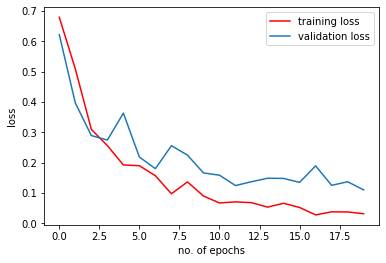

In [13]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('no. of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

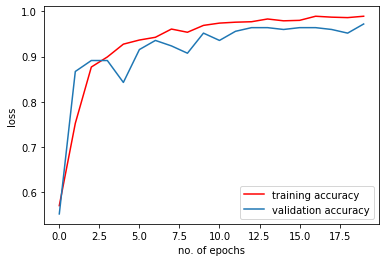

In [14]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('no. of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Detecting masks

In [70]:
haar_cascade_face =cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

label_dict = {0:'NO MASK',1:'MASK'}
color_dict = {0:(255,0,0),1:(0,255,0)}

In [85]:
def detect_faces(cascade, test_image):
    # create a copy of the image to prevent any changes to the original one.
    image_copy = test_image.copy()

    #convert the test image to gray scale as opencv face detector expects gray images
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

    # Applying the haar classifier to detect faces
    faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces_rect:
        face_img = gray_image[y:y+w, x:x+w]
        resized = cv2.resize(face_img,(100,100))
        normalized = resized/255.0
        reshaped = np.reshape(normalized,(1,100,100,1))
        result = classifier.predict(reshaped)
        
        label = np.argmax(result,axis=1)[0]
        
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), color_dict[label], 2)
        cv2.rectangle(image_copy, (x, y-40), (x+w, y), color_dict[label], -1)
        cv2.putText(image_copy, label_dict[label], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

    return image_copy

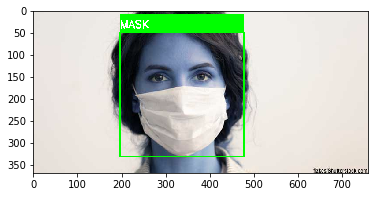

In [89]:
img = cv2.imread('masked_woman.jpg')
img2 = cv2.imread('baby.jpg')
pred = detect_faces(haar_cascade_face, img)
pred2 = detect_faces(haar_cascade_face, img2)
plt.imshow(pred)

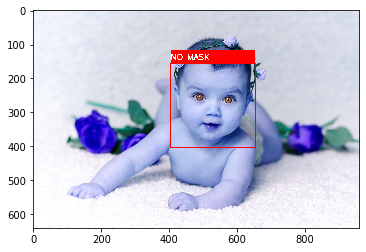

In [90]:
plt.imshow(pred2)